<a href="https://colab.research.google.com/github/victor-armegioiu/Time-Series-Prediction/blob/main/VK_Energie_Stein_Variational_Gradient_Descent_BNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum Project (VK Energie - Forecasting Heat Demand)

# Boilerplate 

This section does necesary imports, loads/parses the data.

In [1]:
# Non-neural based math imports.
import time
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import scipy 
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Data loading
import pandas as pd
import csv

In [3]:
# Drawing stuff.
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('ggplot')

In [4]:
df = pd.DataFrame()
reader = csv.reader(
    open("Oberbayern.csv"), delimiter=";")

rows = [row for row in reader]
df = df.append(rows[1:])

In [5]:
df.columns = ['TimestampUtc', 'Heat Demand', 'Ambient Temperature',  
              'Solar Irradiance']

In [6]:
for column in df.columns[1:]:
  df[column] = df[column].astype(float)

# Data Analysis

This section covers the following analyses on the dataset:


*   Peaking at samples from the data.
*   Missing values count
*   Overall statistics on the regressors/regressands (mean, max, std, etc). Plots for the histograms.
*   Correlation analysis - Making sure the correlations between the features and the targets make sense, as well as ensuring we don't have too strong a linear correlation between the features. 



In [ ]:
df

,TimestampUtc,Heat Demand,Ambient Temperature,Solar Irradiance
0,2020-02-26 17:00:00+01:00,5715.7325,1.370000,0.050000
1,2020-02-26 18:00:00+01:00,5810.5000,0.880000,0.000000
2,2020-02-26 19:00:00+01:00,6059.9000,0.670000,0.000000
3,2020-02-26 20:00:00+01:00,6114.0850,0.600000,0.000000
4,2020-02-26 21:00:00+01:00,6027.0525,0.540000,0.000000
...,...,...,...,...
5941,2020-11-02 12:00:00+01:00,3431.5000,16.787415,5.718750
5942,2020-11-02 13:00:00+01:00,3221.2500,16.833160,7.406250
5943,2020-11-02 14:00:00+01:00,3153.7500,16.731232,2.312500
5944,2020-11-02 15:00:00+01:00,2795.1250,16.396759,7.906250


In [ ]:
df.isnull().sum()

TimestampUtc           0
Heat Demand            0
Ambient Temperature    0
Solar Irradiance       0
dtype: int64

In [ ]:
df.columns

Index(['TimestampUtc', 'Heat Demand', 'Ambient Temperature',
       'Solar Irradiance'],
      dtype='object')

In [ ]:
# Compute and store pairwise correlations between features and
# targets.
correlations = {}
for col1 in df.columns[1:]:
  for col2 in df.columns[1:]:
    if col1 != col2:
      r2_correlation_coeff = stats.pearsonr(df[col1], df[col2])[0]
      correlations[col1, col2] = r2_correlation_coeff

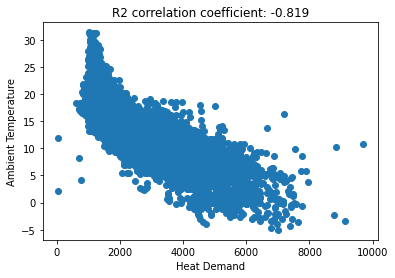

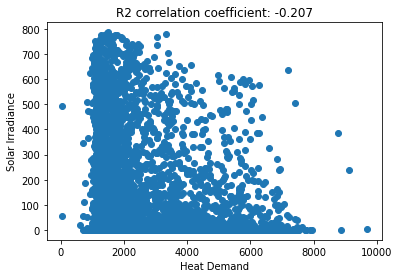

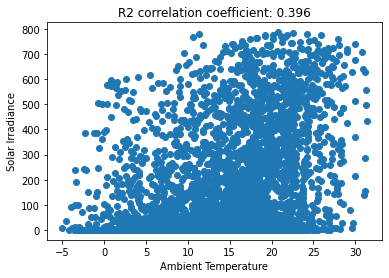

In [ ]:
# Plot all pairwise features/targets/
relevant_columns = df.columns[1:] 

for i in range(len(relevant_columns)):
  for j in range(i + 1, len(relevant_columns)):
    col_i, col_j = relevant_columns[i], relevant_columns[j]
    plt.scatter(df[col_i], df[col_j])
    plt.xlabel(col_i)
    plt.ylabel(col_j)

    r2_correlation_coeff = round(correlations[col_i, col_j], 3)
    plt.title('R2 correlation coefficient: {}'.format(r2_correlation_coeff))
    plt.show()


count    5946.000000
mean     2753.058015
std      1530.114730
min        43.000000
25%      1514.583328
50%      2222.491250
75%      3754.158808
max      9681.533203
Name: Heat Demand, dtype: float64


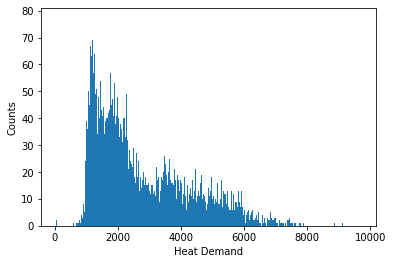


count    5946.000000
mean       13.007976
std         6.339653
min        -5.020000
25%         8.600000
50%        13.198389
75%        17.370000
max        31.371857
Name: Ambient Temperature, dtype: float64


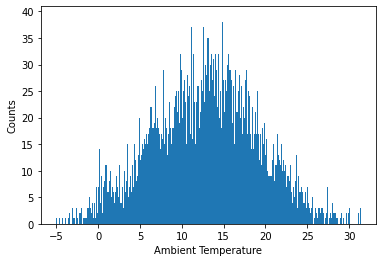


count    5946.000000
mean      105.020707
std       184.026273
min        -0.260000
25%         0.000000
50%         1.812500
75%       131.907500
max       787.470000
Name: Solar Irradiance, dtype: float64


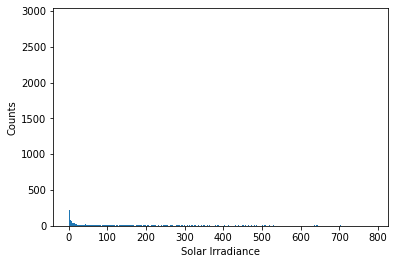

In [ ]:
for column in df.columns[1:]:
  print(df[column].describe())
  plt.hist(df[column], bins=500)
  plt.xlabel(column)
  plt.ylabel('Counts')
  plt.show()
  print()

# Building datasets for training

This section covers the setup needed for creating datasets than can be fed to TensorFlow/PyTorch models. We also do some preprocessing shift/scale our inputs.

In [7]:
def DfTrainTestSplitter(df, test_proportion=0.2, as_numpy=True):
  """Split dataframe into train and test data.
  
  In order to have the test distribution as close as possible to the
  train distribution, we split the initial dataframe into 4 chunks,
  one corresponding from each season.

  We build the test set by concatenating random samples from each season.
  """
  cnt_test = int(test_proportion * len(df))
  season_cnt = 4
  df_train, df_test = None, None

  for i in range(season_cnt):
    left_idx = i * int(len(df) / season_cnt)
    right_idx = min(int(left_idx + cnt_test // 4.0), len(df) - 2)
    
    if df_test is None:
      df_test = df[left_idx: right_idx + 1]
    else:
      df_test = pd.concat([df_test, df[left_idx: right_idx + 1]])

  df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
  if as_numpy:
   return df_train.to_numpy()[:, 1:],  df_test.to_numpy()[:, 1:]
  return df_train, df_test

In [8]:
train_data, test_data = DfTrainTestSplitter(df, test_proportion=0.1)
X_train, y_train = (train_data.astype(float),
                    train_data[:, 0].astype(float))

X_test, y_test = (test_data.astype(float),
                  test_data[:, 0].astype(float))

In [9]:
X_train.shape, X_test.shape

((5350, 3), (596, 3))

In [10]:
scaler = MinMaxScaler().fit(X_train)

In [11]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

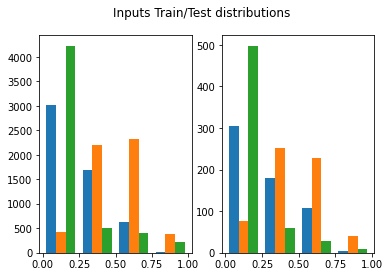

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inputs Train/Test distributions')
ax1.hist(X_train, bins=4)
ax2.hist(X_test, bins=4)
plt.show()

In [13]:
# Scale both dataset by `y_train_max`. Same reasoning
# as in using the same scaler on inputs. This is done to avoid
# exploding gradients.
y_train_max = y_train.max()
y_train /= y_train_max
y_test /= y_train_max

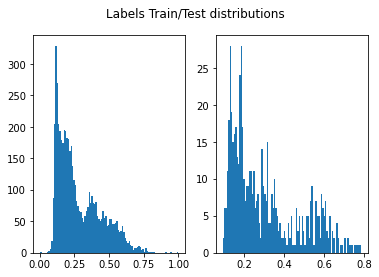

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Labels Train/Test distributions')
ax1.hist(y_train, bins=100)
ax2.hist(y_test, bins=100)
plt.show()

# Batching Logic 

This section defines the necessary utilities for producing batches of variable length sequences.

In [15]:
def GetInitialBatchIndex(X, input_len, prediction_window_len=48):
  """ 
      Returns a random index from which to sample `input_len` inputs.
      This was written separately so that we can test that it produces an
      even distribution among potential starting indices.
  """
  left_idx = np.random.randint(
      low=0,
      high=max(len(X) - prediction_window_len * 2 - input_len - 1, 1))
  right_idx = left_idx + input_len - 1
  return left_idx

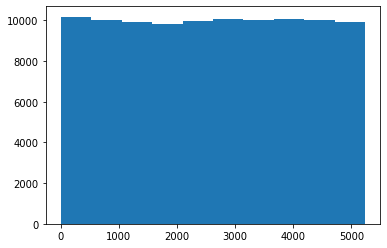

In [16]:
# Confirm that starting indices for bathches are evenly distributed.
no_trials = 100000
start_indices_samples = []

for _ in range(no_trials):
  start_indices_samples.append(GetInitialBatchIndex(X_train, 15))

plt.hist(start_indices_samples)
plt.show()

In [17]:
def GetSample(X, y, input_len, prediction_window_len=48, use_noise_reg=False):
  """Return a single input sequence and its respective targets.
  
  Args:
    X: np.array from which to extract input sequences.
    y: np.array from which to extract the regression targets corresponding
       to the selected inputs.
    prediction_window_len: length of the prediction window, which describes
      how many predictions we have to do for a given input sequence.
    use_noise_reg: bool indication whether to inject the labels with noise.

  Return:
    X_tensor: tensorized inputs.
    y_tensor: tensorized targets.

  Note, since we can use forecasts, we also include future data in our
  sequences.
  """
  left_idx = GetInitialBatchIndex(X, input_len, prediction_window_len)
  right_idx = left_idx + input_len - 1

  # Add `prediction_window_len` to our right index, since we can use future
  # values as well, given that we always expect to have forecasts availabel.
  X_sample = X[left_idx : right_idx + 1 + prediction_window_len]
  y_sample = y[right_idx + 1 : right_idx + prediction_window_len + 1]

  return X_sample, y_sample

In [18]:
def GetBatch(X, y, batch_size, input_len, prediction_window_len=48,
             use_noise_reg=False):
  Xs, ys = [], []
  for _ in range(batch_size):
    X_sample, y_sample = GetSample(X, y, 
                                   input_len,
                                   prediction_window_len,
                                   use_noise_reg)
    Xs.append(X_sample)
    ys.append(y_sample)
  return np.stack(Xs), np.stack(ys)

In [30]:
xb, yb = GetBatch(X_train, y_train, 10, 1)
xb.shape, yb.shape

((10, 49, 3), (10, 48))

# Training Bayesian Neural Nets with Stein Variational Gradient Descent

Citation:
*Qiang Liu and Dilin Wang. Stein Variational Gradient Descent (SVGD): A General Purpose Bayesian Inference Algorithm. NIPS, 2016.*

The `SVGDOptimizer.Optimize()` method will treat a bunch of neural nets as particles, via flattening their variables and corresponding log-likelihood gradients. The overall objective is to maximize the log-likelihood of the data under the ensemble of particles, and ensure that kernelized distance between them is maximized - this ensures that we maintain diversity between the particles, and drives the particles away from collapsing to the $\text{MAP}$ estimate.

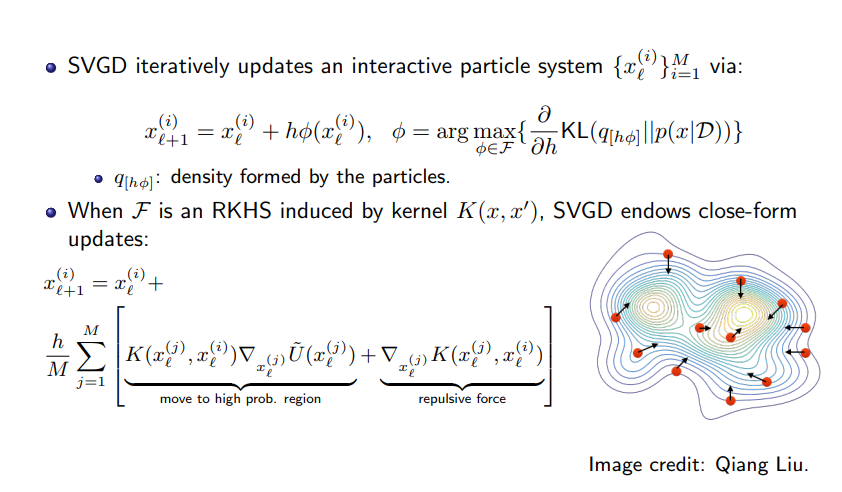

In [40]:
class SVGDOptimizer(object):
  def __init__(self, grads_list, vars_list, optimizer, median_heuristic=True):
      self.grads_list = grads_list
      self.vars_list = vars_list
      self.optimizer = optimizer
      self.num_particles = len(vars_list)
      self.median_heuristic = median_heuristic

  @staticmethod
  def GetKernel(flatvars_list, median_heuristic=True):
      stacked_vars = tf.stack(flatvars_list)
      norm = tf.reduce_sum(stacked_vars * stacked_vars, 1)
      norm = tf.reshape(norm, [-1, 1])
      pairwise_dists = (
          norm - 2 * 
          tf.matmul(stacked_vars, tf.transpose(stacked_vars)) +
          tf.transpose(norm))

      # For median in TensorFlow, I use the following reference:
      # https://stackoverflow.com/questions/43824665/tensorflow-median-value
      def _percentile(x, interpolation):
          return tfp.stats.percentile(x, 50.0, interpolation=interpolation)

      if median_heuristic:
          median = (_percentile(pairwise_dists, 'lower')
            + _percentile(pairwise_dists, 'higher')) / 2.
          median = tf.cast(median, tf.float32)
          h = tf.sqrt(0.5 * median / tf.math.log(len(flatvars_list) + 1.))

      if len(flatvars_list) == 1:
          h = 1.

      # Kernel computation and distance derivatives with respect to the
      # particles.
      Kxy = tf.exp(-pairwise_dists / h ** 2 / 2)
      dxkxy = -tf.matmul(Kxy, stacked_vars)
      sumkxy = tf.math.reduce_sum(Kxy, axis=1, keepdims=True)
      dxkxy = (dxkxy + stacked_vars * sumkxy) / tf.pow(h, 2)
      return Kxy, dxkxy

  def Optimize(self):
      flatgrads_list, flatvars_list = [], []

      for grads, vars in zip(self.grads_list, self.vars_list):
          flatgrads, flatvars = self.flatten_grads_and_vars(grads, vars)
          flatgrads_list.append(flatgrads)
          flatvars_list.append(flatvars)

      Kxy, dxkxy = self.GetKernel(flatvars_list, self.median_heuristic)
      stacked_grads = tf.stack(flatgrads_list)
      stacked_grads = (tf.matmul(Kxy, stacked_grads) + dxkxy)
      stacked_grads /= self.num_particles
      flatgrads_list = tf.unstack(stacked_grads, self.num_particles)

      # Reshape gradients for each particle in correct form.
      grads_list = []
      for flatgrads, vars in zip(flatgrads_list, self.vars_list):
          start = 0
          grads = []
          for var in vars:
              shape = self.var_shape(var)
              size = int(np.prod(shape))
              end = start + size
              grads.append(tf.reshape(flatgrads[start:end], shape))
              start = end
          grads_list.append(grads)

      for grads, vars in zip(grads_list, self.vars_list):
          self.optimizer.apply_gradients(
              [(-g, v) for g, v in zip(grads, vars)])

  def flatten_grads_and_vars(self, grads, vars):
      """Flatten gradients and variables.
      (from openai/baselines/common/tf_util.py)
      :param grads: list of gradients
      :param vars: list of variables
      :return: two lists of flattened gradients and varaibles
      """
      flatgrads = tf.concat(axis=0, values=[
          tf.reshape(grad if grad is not None else tf.zeros_like(var), [self.num_elements(var)])
          for (var, grad) in zip(vars, grads)])
      flatvars = tf.concat(axis=0, values=[
          tf.reshape(var, [self.num_elements(var)])
          for var in vars])
      return flatgrads, flatvars

  def num_elements(self, var):
      return int(np.prod(self.var_shape(var)))

  @staticmethod
  def var_shape(var):
      out = var.get_shape().as_list()
      assert all(isinstance(a, int) for a in out), \
          'shape function assumes that shape is fully known'
      return out

In [27]:
# An ensemble of these models will represent our set of particles.
# You can use any differentiable model you like here.
def GetBaseModel(input_shape, prediction_window_len=48):
  model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape,name="input"),
    tf.keras.layers.Convolution1D(
        64, kernel_size=5, padding='SAME', activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(prediction_window_len,
                            activation=tf.nn.relu, name="output"),
  ])
  return model

In [39]:
# Sample usage.
n_particles = 5
particles = [GetBaseModel(input_shape=(49, 3)) for _ in range(n_particles)]
tpred = tf.stack([particle(xb) for particle in particles])
print(tf.reduce_mean(tpred, axis=0).shape, yb.shape)

(5, 10, 48) (10, 48)


In [95]:
n_particles = 5
seq_len = 1
input_shape = (49, 3)
particles = [GetBaseModel(input_shape=input_shape) for _ in range(n_particles)]

optimizer = tf.keras.optimizers.Adam(0.01)
criterion = tf.keras.losses.MeanSquaredError()
epochs = 2
batch_size = 32
iter_per_epochs = len(X_train) // batch_size

for epoch in range(epochs):
  for i in range(iter_per_epochs):
    with tf.GradientTape(persistent=True) as g:
      x_batch_train, y_batch_train = GetBatch(X_train, y_train,
                                              batch_size, seq_len)
      predictions = tf.stack([particle(x_batch_train)
      for particle in particles])
      predictions = tf.reduce_mean(predictions, axis=0)
      log_likelihood = -criterion(predictions, y_batch_train)

    grads_list = []
    vars_list = []

    for particle in particles:
      grads = g.gradient(log_likelihood, particle.trainable_variables)
      grads_list.append(grads)
      vars_list.append(particle.trainable_variables)

    # Gradient ascent for log likelihood and SVGD kernel repulsive forces.
    svgd_optimizer = SVGDOptimizer(grads_list, vars_list, optimizer)
    svgd_optimizer.Optimize()

    if i % 10 == 0:
      print('Epoch [%d], iteration [%d] test log-likelihood (-MSE): [%f]' % 
            (epoch, i, log_likelihood.numpy(),))

Epoch [0], iteration [0] test log-likelihood (-MSE): [-0.092260]
Epoch [0], iteration [10] test log-likelihood (-MSE): [-0.014975]
Epoch [0], iteration [20] test log-likelihood (-MSE): [-0.006269]
Epoch [0], iteration [30] test log-likelihood (-MSE): [-0.004386]
Epoch [0], iteration [40] test log-likelihood (-MSE): [-0.005113]
Epoch [0], iteration [50] test log-likelihood (-MSE): [-0.005042]
Epoch [0], iteration [60] test log-likelihood (-MSE): [-0.004027]
Epoch [0], iteration [70] test log-likelihood (-MSE): [-0.002793]
Epoch [0], iteration [80] test log-likelihood (-MSE): [-0.002313]
Epoch [0], iteration [90] test log-likelihood (-MSE): [-0.002728]
Epoch [0], iteration [100] test log-likelihood (-MSE): [-0.002953]
Epoch [0], iteration [110] test log-likelihood (-MSE): [-0.002887]
Epoch [0], iteration [120] test log-likelihood (-MSE): [-0.002635]
Epoch [0], iteration [130] test log-likelihood (-MSE): [-0.003258]
Epoch [0], iteration [140] test log-likelihood (-MSE): [-0.001944]
Epoch 

## Test the learned ensemble of particles on the test dataset.

In [109]:
test_batch_size = 32
test_iterations = len(X_test) // test_batch_size
test_maes = []

for i in range(test_iterations):
  X_test_batch, y_test_batch= GetBatch(X_test, y_test, test_batch_size, seq_len)
  predictions = tf.stack([particle(X_test_batch, training=False)
      for particle in particles])
  predictions = tf.reduce_mean(predictions, axis=0)
  test_maes.append(tf.keras.losses.mae(y_test_batch, predictions))

print('Test MAE:', tf.reduce_mean(test_maes).numpy() * y_train_max)

Test MAE: 300.39834790727076


Mean Absolute Error: 199.69336444413648


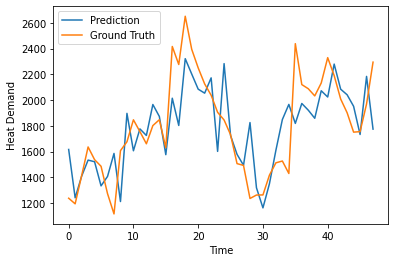

In [103]:
X_sample, y_sample = GetBatch(X_test, y_test, 1, seq_len)

plt.ylabel('Heat Demand')
plt.xlabel('Time')

predictions = tf.stack([particle(X_sample, training=False)
    for particle in particles])
predictions = tf.reduce_mean(predictions, axis=0)

plt.plot(predictions.numpy().flatten() * y_train_max)
plt.plot(y_sample.flatten() * y_train_max)
plt.legend(['Prediction', 'Ground Truth'], loc='upper left')

mae = tf.math.reduce_mean(tf.abs(predictions.numpy() - y_sample) *
                          y_train_max).numpy()
print('Mean Absolute Error:', mae)

plt.show()